In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
n = np.arange(0, 100, 1)

# Comparison

In this document, we compare PROV, PROV-Dictionary and Versioned-PROV


## List Definition

For the list `[1, 2, 1]`, we have 2 entities to represent the literals `1` and `2` in all mappings:
```
entity(1, [value="1", type="name", generatedAtTime="T1"]) 
entity(2, [value="2", type="name", generatedAtTime="T2"])
```
Note that `generatedAtTime` is an optional prov attribute, but it is advisable to use it in Versioned-PROV. Thus, we represent all entities with this attribute. 


Besides these 2 entities, all mappings have an entity to represent the list definition itself, but the `type` attribute of the mappings change. In PROV and Versioned-PROV, the `type` must be a `prov:Collection`. In PROV-Dictionary, the `type` must be a `prov:Dictionary`. Note that all entity types that we use in the `script` namespace that we use in the examples (except `script:literal`, and `script:constant`) are subtype of `prov:Collection`, even when they do not represent collections. 
```
entity(list, [value="[1, 2, 1]", type="X", label="[1, 2, 1]", generatedAtTime="T3"])
```

The Plain PROV mapping use the `hadMember` statement to define members of the list. This statement does not indicate the position of the elements in the list. Since this information is important to reconstruct the path in the provenance query of Floyd-Warshall, we create extra nodes that encode the list position and we derive theses nodes from the original literal entities, by using the `definelist` activity:
```
activity(definelist1, [type="script:definelist"])
wasGeneratedBy(list, definelist1, -)

entity(list0, [value="1", type="script:item", label="1"])
hadMember(list, list0)
used(u1; definelist1, 1, -)
wasGeneratedBy(g1; list0, definelist1, -)
wasDerivedFrom(list0, 1, definelist1, g1, u1)

entity(list1, [value="1", type="script:item", label="2"])
hadMember(list, list1)
used(u2; definelist1, 2, -)
wasGeneratedBy(g2; list1, definelist1, -)
wasDerivedFrom(list1, 2, definelist1, g2, u2)

entity(list2, [value="2", type="script:item", label="1"])
hadMember(list, list2)
used(u3; definelist1, 1, -)
wasGeneratedBy(g3; list2, definelist1, -)
wasDerivedFrom(list2, 1, definelist1, g3, u3)
```
Thus, for defining a list with `N` elements in PROV, we have:
- `1` `activity`
- `1 + N` `entity`
- `N` `hadMember`
- `N` `used`
- `N` `wasDerivedFrom`
- `1 + N` `wasGeneratedBy`,
- `= 3 + 5N` constructs

In addition to all `entities` that appear in the list.


Different from Plain PROV, PROV-Dictionary can define list elements with their positions, and can use a single statement, `wasDerivedByInsertionFrom`, to associate member entities to a collection entity. However, since it does not indicate the position of accesses, we still need to create extra entities to encode the position. Additionally, we also need a global `EmptyDictionary` entity for the derivation:
```
entity(empty, [value="[]", type="EmptyDictionary"])

activity(definelist1, [type="script:definelist"])
wasGeneratedBy(list, definelist1, -)

entity(list0, [value="1", type="script:item", label="1"])
used(u1; definelist1, 1, -)
wasGeneratedBy(g1; list0, definelist1, -)
wasDerivedFrom(list0, 1, definelist1, g1, u1)

entity(list1, [value="1", type="script:item", label="2"])
used(u2; definelist1, 2, -)
wasGeneratedBy(g2; list1, definelist1, -)
wasDerivedFrom(list1, 2, definelist1, g2, u2)

entity(list2, [value="2", type="script:item", label="1"])
used(u3; definelist1, 1, -)
wasGeneratedBy(g3; list2, definelist1, -)
wasDerivedFrom(list2, 1, definelist1, g3, u3)

derivedByInsertionFrom(
    list, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)
```
Thus, for defining a list with `N` elements in PROV-Dictionary, we have:
- `1` `activity`
- `1 + N` `entity`
- `1` `derivedByInsertionFrom`
- `N` `used`
- `N` `wasDerivedFrom`
- `1 + N` `wasGeneratedBy`,
- `= 4 + 4N` constructs + `1` global `EmptyDictionary` entity

In addition to all `entities` that appear in the list.


Versioned-PROV is capable of defining list elements with their positions using the `hadMember` statement with extra attributes, and it also indicates the accessed positions. Thus, Versioned-PROV queries can handle list accesses without requiring extra constructs:
```
hadMember(list, 1, [type="versioned:Insertion", versioned:key="0", versioned:moment="T3"])
hadMember(list, 2, [type="versioned:Insertion", versioned:key="1", versioned:moment="T3"])
hadMember(list, 1, [type="versioned:Insertion", versioned:key="2", versioned:moment="T3"])
```
Thus, for definining a list witn `N` elements in Versioned-PROV, we have
- `1` `entity` for the list
- `N` `hadMember`
- `= 1 + N` constructs

In addition to all `entities` that appear in the list.



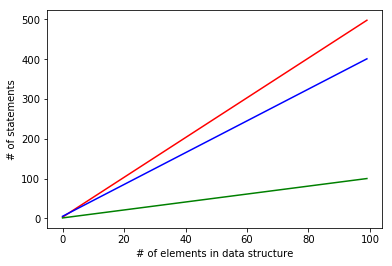

In [2]:
def prov(n, count, color):
    return (n, count * (3 + 5 * n), color)

def dic(n, count, color):
    return (n, 1 + count * (4 + 4 * n), color)

def ver(n, count, color):
    return (n, count * (1 + n), color)

plt.plot(*prov(n, 1, 'r'), *dic(n, 1, 'b'), *ver(n, 1, 'g'))
ax = plt.gca()
ax.set_xlabel("# of elements in data structure")
ax.set_ylabel("# of statements")
plt.show()

## Reference assignment

Common assignments of imutable values produce the same number of elements in all the mappings. However, the assignment of references to data structures requires recreating the membership relationships in Plain PROV and PROV-Dictionary.

In all mappings, we have the following statements to represent `d = [1, 2, 1]`:
```
entity(d, [value="[1, 2, 3]", type="script:name", label="d", generatedAtTime="T4"])
activity(assign1, [type="script:assign"])
used(ua1; assign1, list, -)
wasGeneratedBy(ga1; d, assign1, -)
wasDerivedFrom(d, list, assign1, gua1, ua1, [type="versioned:Reference", versioned:moment="T7"])
```
Once again, the attributes of `entity` and `wasDerivedFrom` refer to the Versioned-PROV mapping. The other mappings do not require the attribute `generatedAtTime` in the `entity` and do not have the `versioned:moment` attribute nor the `versioned:Reference` type in the `wasDerivedFrom`.


The Plain PROV mapping uses `hadMember` relationships to define the memberships:
```
hadMember(d, list0)
hadMember(d, list1)
hadMember(d, list2)
```
Thus, we use N statements for a list of N elements

The PROV-Dictionary mapping uses a single `derivedByInsertionFrom` to define the memberships:
```
derivedByInsertionFrom(
    d, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)
```

Finally, the Versioned-PROV mapping does not require any additional constructs other than the attributes in `wasDerivedFrom`. Hence assignments of imutable or mutable values in Versioned-PROV are represented the same way.

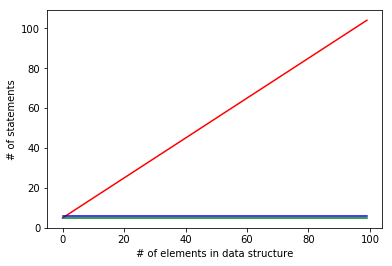

In [3]:
def prov(n, count, color):
    return (n, count * (5 + n), color)

def dic(n, count, color):
    return (n, count * (6 + n * 0), color)

def ver(n, count, color):
    return (n, count * (5 + n * 0), color)

plt.plot(*prov(n, 1, 'r'), *dic(n, 1, 'b'), *ver(n, 1, 'g'))
ax = plt.gca()
ax.set_xlabel("# of elements in data structure")
ax.set_ylabel("# of statements")
plt.show()

## Assignment to part of structures

An assignment to a part of a structure is similar to an assignment, but it has to update that membership of the structure. In all mappings, to represent `d[1] = 3` we have the following statements in common:
```
entity(3, [value="3", type="name", generatedAtTime="T4"]) 
entity(d_ac1, [value="3", type="script:access", label="d[1]", generatedAtTime="T5"])
activity(assign2, [type="script:assign"])
used(assign2, 1, -)
used(ua2; assign2, 3, -)
wasGeneratedBy(ga2; d_ac1, assign2, -)
wasDerivedFrom(d_ac1, 3, assign2, ga2, ua2, [
    type="versioned:Reference", versioned:moment="T5",
    versioned:whole="d", versioned:key="1", versioned:access="w"])
```
The attributes of `entity` and `wasDerivedFrom` refer to the Versioned-PROV mapping. The other mappings do not require the attribute `generatedAtTime` in the `entity` and do not have the attributes that we used in `wasDerivedFrom`.

This snippet deals with the generation of the new member entity, but it does not deal with the update of the collection entity. The update on the collection entity should occur not only on the collection being updated, but also to all collections that share its reference.
Each mapping tackles this update differently. 

Plain PROV has no semantics to update the membership of an entity. Thus, it is necessary to create a new `entity` for every collection that reference the same data structures and redefine its structure:
```
entity(d#2, [value="[1, 3, 1]", type="script:name", label="d"])
used(ua3; assign2, d, -)
wasGeneratedBy(ga3; d#2, assign2, -)
wasDerivedFrom(d#2, d, assign2, ga3, ua3)
wasDerivedFrom(d#2, 3, assign2, ga3, ua2)
hadMember(d#2, list0)
hadMember(d#2, d_ac1)
hadMember(d#2, list2)

entity(list#2, [value="[1, 3, 1]", type="script:list"])
used(ua4; assign2, list, -)
wasGeneratedBy(ga4; list#2, assign2, -)
wasDerivedFrom(list#2, list, assign2, ga4, ua4)
wasDerivedFrom(list#2, 3, assign2, ga4, ua2)
hadMember(list#2, list0)
hadMember(list#2, d_ac1)
hadMember(list#2, list2)
```
For updating a data structure that share R references and N elements, we have:
- `1` `activity`
- `1 + R` `entity`
- `2 + R` `used`
- `1 + R` `wasGeneratedBy`
- `1 + 2R` `wasDerivedFrom`
- `R * N` `hadMember`
- `R * (N + 5) + 6` constructs
In addition to the entities that are used to indicate the position and the assigned value.

This, however, is a lower bound. If `d` or `list` were a member of another collection, we would have to update the parent collection in a similar way. Additionally, if the entity on the right side were an assignment, we would have to update the membership of `d_ac1` as described before.

PROV-Dictionary can use the `derivedByInsertionFrom` statement to derive new collections based on existing ones. Thus, the number of constructs is smaller:
```
entity(d#2, [value="[1, 3, 1]", type="Dictionary", label="d"])
used(ua3; assign2, d, -)
wasGeneratedBy(ga3; d#2, assign2, -)
wasDerivedFrom(d#2, d, assign2, ga3, ua3)
wasDerivedFrom(d#2, 3, assign2, ga3, ua2)
derivedByInsertionFrom(d#2, d, {("1", d_ac1)})

entity(list#2, [value="[1, 3, 1]", type="Dictionary"])
used(ua4; assign2, list, -)
wasGeneratedBy(ga4; list#2, assign2, -)
wasDerivedFrom(list#2, list, assign2, ga4, ua4)
wasDerivedFrom(list#2, 3, assign2, ga4, ua2)
derivedByInsertionFrom(list#2, list, {("1", d_ac1)})
```
For updating a data structure that share R references and N elements, we have:
- `1` `activity`
- `1 + R` `entity`
- `2 + R` `used`
- `1 + R` `wasGeneratedBy`
- `1 + 2R` `wasDerivedFrom`
- `R` `derivedByInsertionFrom`
- `= 6R + 6` constructs

This is a lower bound again, as it would require updating parent collections or adding membership of the right side in other situations.

Finally, in Versioned-PROV we use the `hadMember` on the collection that defined the reference and a timestamp to indicate when it became a valid member of the collection. All references that share the reference do not need to be updated, since we can follow the references using the `type="versioned:Reference"` in `wasDerivedFrom` statements:
```
used(assign2, d, -)
hadMember(list, d_ac1, [type="versioned:Insertion", versioned:key="1", versioned:moment="T5"])
```
For updating a data structure that share R references and N elements, we have:
- `1` `activity`
- `1` `entity`
- `3` `used`
- `1` `wasGeneratedBy`
- `1` `wasDerivedFrom`
- `1` `hadMember`
- `= 8` constructs

Note that we do not need to change any other collection in this case, nor define membership relationships do `d_ac1`, due to the derivation `type="versioned:Reference"`. Hence, this number is at the same time the lower bound and the upper bound of an assignment in the format `COLLECTION[KEY] = VALUE`


* In this example, we update the entity `list` as it also refers to `d`, but in an actual execution, the `list` reference is not valid anymore at this point of the execution, since it represents only the list definition. However, all other variables that share a reference with `d` would still be updated this way.



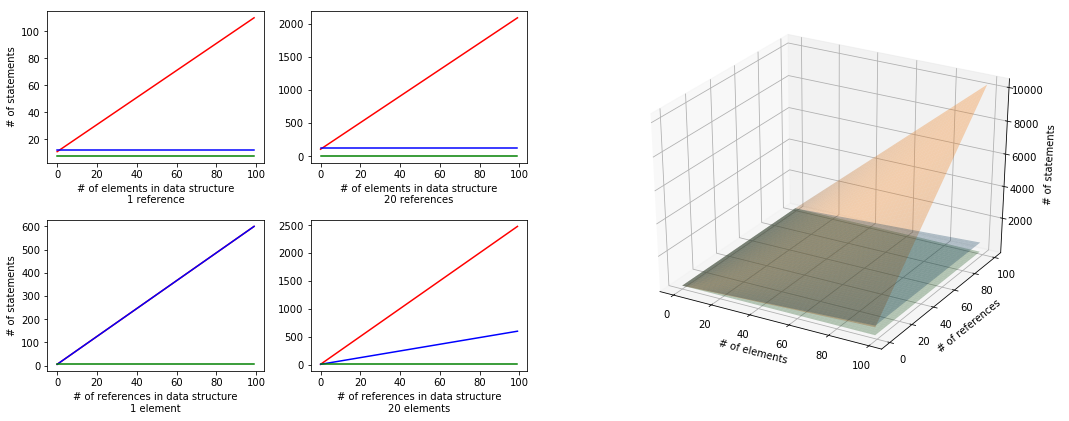

In [4]:
from mpl_toolkits.mplot3d import Axes3D
def prov(n, r, count, color, axis=[]):
    return axis + [count * (r * (n + 5) + 6), color]

def dic(n, r, count, color, axis=[]):
    return axis + [count * (6 * r + 6 + n * 0), color]

def ver(n, r, count, color, axis=[]):
    return axis + [count * (8 + n * 0 + r * 0), color]

f, (
    (ax00, ax01, ax02, ax03),
    (ax10, ax11, ax12, ax13),
) = plt.subplots(2, 4, sharey=False)
ax00.plot(*prov(n, 1, 1, 'r', [n]), *dic(n, 1, 1, 'b', [n]), *ver(n, 1, 1, 'g', [n])) 
ax00.set_xlabel("# of elements in data structure\n1 reference")
ax00.set_ylabel("# of statements")

ax01.plot(*prov(n, 20, 1, 'r', [n]), *dic(n, 20, 1, 'b', [n]), *ver(n, 20, 1, 'g', [n])) 
ax01.set_xlabel("# of elements in data structure\n20 references")


ax10.plot(*prov(1, n, 1, 'r', [n]), *dic(1, n, 1, 'b', [n]), *ver(1, n, 1, 'g', [n])) 
ax10.set_xlabel("# of references in data structure\n1 element")
ax10.set_ylabel("# of statements")

ax11.plot(*prov(20, n, 1, 'r', [n]), *dic(20, n, 1, 'b', [n]), *ver(20, n, 1, 'g', [n])) 
ax11.set_xlabel("# of references in data structure\n20 elements")


ax02.axis('off')
ax03.axis('off')
ax12.axis('off')
ax13.axis('off')

R, N = np.meshgrid(np.arange(0, 100, 1), n)
ax3 = f.add_subplot(122, projection='3d')
ax3.plot_surface(*dic(N, R, 1, 'r', [R, N])[:-1], alpha=0.3)
ax3.plot_surface(*prov(N, R, 1, 'r', [R, N])[:-1], alpha=0.3)
ax3.plot_surface(*ver(N, R, 1, 'r', [R, N])[:-1], alpha=0.3)
ax3.set_xlabel("# of elements")
ax3.set_ylabel("# of references")
ax3.set_zlabel("\n# of statements")

f.set_size_inches(15, 6)
plt.tight_layout()
plt.show()